# ENGR 76 Project 2b: Filtering and Frequency-division multiplexing

_Due: 2025_

<font color='blue'>**YOUR STANFORD EMAIL:**</font>     @stanford.edu

If your transmission is the only sound in the room, then the receiver can just listen to it and decode it to recover the message, as you did in Project 2a. But in reality, we never have such a happy monopoly on the transmission environment. Rather, the receiver will have to deal with other sounds, like other background noise, conversations or other transmitters. Any sound that isn't the transmitted signal is called _noise_. This week, we'll explore how filtering can be used to remove noise and extract the signal.

<div class="alert alert-info">
    Wireless communication, including 4G, Wi-Fi, Bluetooth, FM radio and GPS signals, has the same problem—both from other wireless transmitters and from other sources of electromagnetic energy. The techniques they use to extract their signal of interest are similar.
</div>

In this project, you will:

- Establish how to work with the FFT as a practical approximation for a signal's spectrum
- Inspect the spectra of your transmitted OOK signal, and your received one, with and without noise
- Apply filtering to the received noisy signal and show that filtering improves the bit error rate
- Investigate how different frequency bands can be used for independent transmissions
- Implement frequency multiplexing to increase the data rate of your system
- Consider how frequency multiplexing can be used to allow several systems to transmit in the same space

<div class="alert alert-info" style="color:black;">
    <p>
        <strong>Where we are in Project 2.</strong>
    </p>
    <p style="text-align: center;">
        <img src="img/proj2b-where.png" style="height: 84px;" />
    </p>
</div>

<div class="alert alert-info" style="color: black;"><strong>Answer formatting:</strong> As usual, we've left <code>&gt; YOUR ANSWER HERE</code> in cells where we want you to type in answer. To do so, double-click the cell, and please leave the <code>&gt;</code> there (and start each paragraph with <code>&gt;</code>) so that the blockquote bar on the left remains next to your answer.</div>

<div class="alert alert-warning">Throughout Project 2, you may reuse some recorded signals across different code cells. To prevent loading incorrect signals, <b>pay additional attention to your variable names to ensure they are not accidentally overwritten.</b></div>


In [84]:
# Packages you should already have installed, to be imported:

import numpy as np

π = np.pi

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 5)  # make the graphs wider

from numpy.random import default_rng

rng = default_rng()

# setting up the channels
save_wav = False #SET TO TRUE IF AUDIO IS NOT WORKING
from channel import Channel, save
from functools import partial

channel = Channel()
channel0 = partial(channel.transmit, save_wav=save_wav)
channel1 = partial(channel.transmit, talking=True, save_wav=save_wav)
channel2 = partial(channel.transmit, clap=True, save_wav=save_wav)

import IPython.display as ipd

# Part 1: Getting to know the FFT

The _fast Fourier transform_ (FFT) is an algorithm for the _discrete Fourier transform_ (DFT), which is a version of the Fourier transform suitable for discrete-time, finite-length signals.

<div class="alert alert-info"><strong>Note on terminology:</strong> The FFT is a <em>method of computing</em> the DFT, so mathematically, it makes more sense to think of this as working with the DFT. But because the FFT is by far the most common way of computing the DFT, engineers often colloquially just talk about the FFT, and use the two terms interchangeably.</div>

Technically, the FFT works on discrete-time signals,
$$x[n], \quad n = 0, \dots, N-1,$$
and returns a frequency-domain representation that is one more than half the length. We can call this $x_\mathcal F$:
$$x_\mathcal{F}[n], \quad n = 0, \dots, \lfloor N/2 \rfloor.$$

However, we often want to use the FFT as an **approximation** to the continuous-time Fourier transform. For example, say that $x[n]$ was a sampled version of a continuous-time signal $\tilde x(t)$ at sampling frequency $f_s$ ,

$$x[n] = \tilde x(t[n]), \qquad t[n] = \frac{n}{f_s}.$$

Recall from last week that to plot this signal using `plt.plot()` in a way that makes sense for “the real world”, we plot the time vector $t[n]$ against the signal vector $x[n]$. Similarly, when working with the FFT $x_\mathcal{F}[n]$, we'll want to plot it against some sort of “frequency vector”
$$f[n], \quad n = 0, \dots, \lfloor N/2 \rfloor.$$

Our goal in this part is to establish how to think about what $f[n]$ should be.

### FFT of a pure tone

Let's start with a **pure tone**.

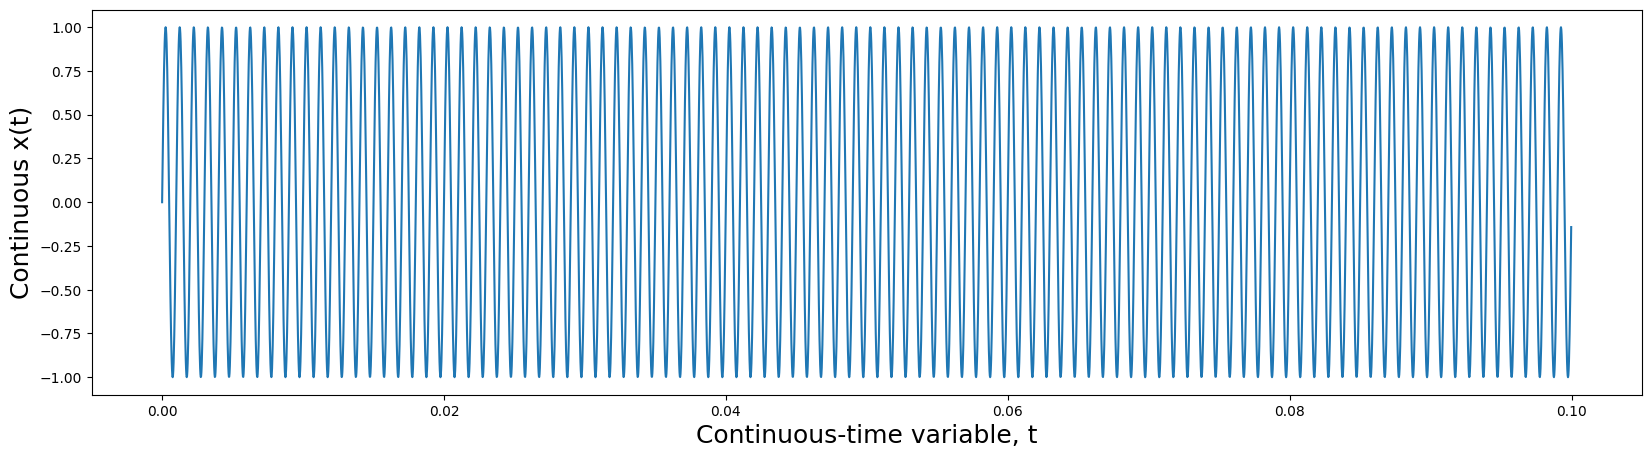

In [85]:
# feel free to play with these numbers and then re-run subsequent cells
tmax = 0.1  # end of signal in "real" time (seconds)
fs = 44100  # sampling frequency
f = 1000  # frequency of tone
t = np.arange(0, tmax, 1 / fs)  # time vector t[n]
x = np.sin(2 * π * f * t)  # signal vector x[n]

# plot signal in time domain
plt.plot(t, x)
plt.xlabel('Continuous-time variable, t', size=18)
plt.ylabel('Continuous x(t)', size=18)
plt.show()

We can take the FFT using the `rfft()` function, which is in the the `scipy.fft` module.

In [86]:
# import relevant functions
from scipy.fft import rfft, irfft, rfftfreq

If you inspect the spectrum `rfft(x)`, you'll notice that its entries are complex (_i.e._, have real and imaginary parts, corresponding to cosine and sine components). To visualize it effectively as a plot, it's common to take its absolute value (also known as its modulus). That is, instead of plotting $x_\mathcal{F}[n]$ (called `x_fft` below), we instead plot $|x_\mathcal{F}[n]|$.

complex128


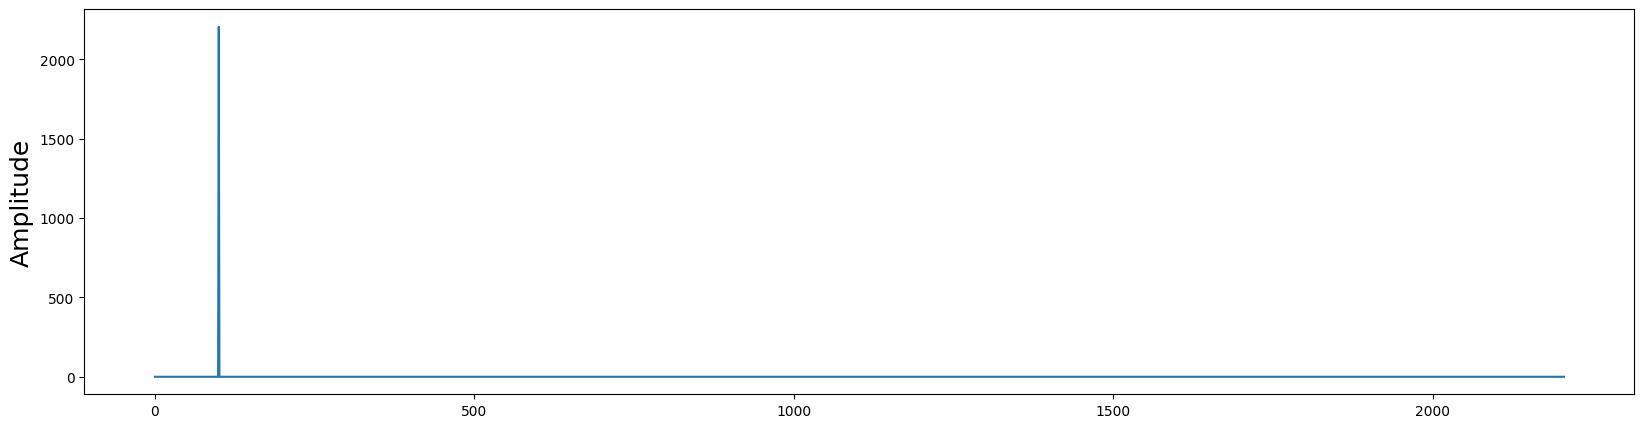

In [87]:
x_fft = rfft(x)
print(x_fft.dtype)
plt.plot(np.abs(x_fft))
plt.ylabel('Amplitude', size=18)
plt.show()

One problem: The above code plots with respect to frequency "indices" $n$, which aren't very meaningful here. That spike should be at whatever `f` was set to above.

<div class="alert alert-warning">This is a key distinction between our work in this project, and our study of the DCT for images in Project 1b. In Project 1b, the “duration” of the signal (<i>i.e.</i> size of the image) had no physical meaning, so we ignored the units. Here, time is <em>measured in seconds</em> and frequency is <em>expressed in Hertz</em> (the reciprocal of seconds), so we have to be more precise with our handling of frequencies.</div>

Whenever we need to plot the FFT of a signal, we also need to generate a vector of frequencies, so that the horizontal axis is scaled appropriately. To establish the scaling, note the following:
- The number of elements in the FFT output is half the length of the original signal $N$
- The highest frequency that the original signal can capture is half the sampling frequency $f_s$

The frequency vector is therefore given by

$$f[n] = \frac{f_s/2}{N/2} \cdot n = \frac{f_s}{N} \cdot n = \frac{1}{N T_s} \cdot n, \qquad \text{for } n = 0, \dots, \lfloor N/2 \rfloor.$$

where $N$ is the length of the signal vector $x[n]$, $f_s$ is the sampling frequency, and $T_s = 1/f_s$ is the sampling period.

NumPy provides a convenience function that does this for us. It's called `rfftfreq`, and it takes two arguments: the length of the original signal $N$, and the sampling period $T_s$.

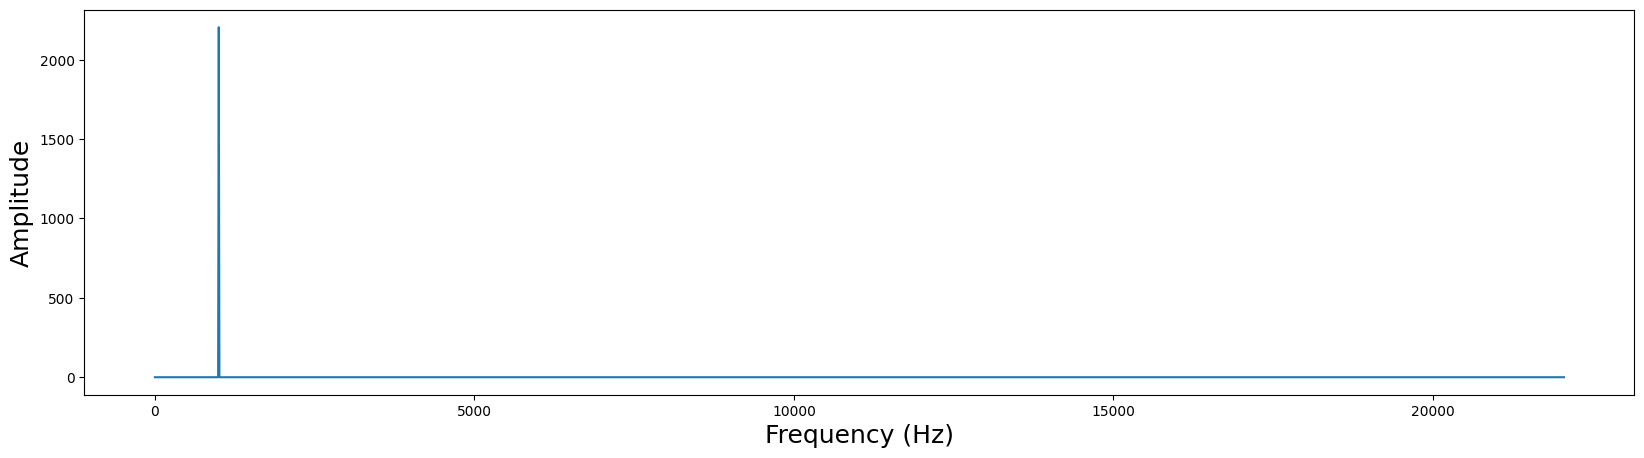

In [88]:
Ts = 1 / fs
f_fft = rfftfreq(x.size, Ts)  # equivalent to: np.arange(x_fft.size) * fs / x.size
x_fft = rfft(x)

plt.plot(f_fft, np.abs(x_fft))
plt.xlabel("Frequency (Hz)", size=18)
plt.ylabel("Amplitude", size=18);

So to summarize, to use the FFT as an approximation for the continuous-time Fourier transform, we do what's in the above cell.

<div class="alert alert-info">
    <p><strong>More than you needed to know:</strong> The <code>r</code> in <code>rfft()</code> stands for “real”, signalling that <code>rfft()</code> computes the FFT on the assumption that the signal is real (<i>i.e.</i>, without imaginary part), which ours is. The frequency-domain representation (FFT output), however, is still complex (<i>i.e.</i>, has an imaginary part).</p>
    <p>Then what does the real assumption buy us? The standard <code>fft()</code> computes the FFT assuming that the input might be complex. This gives rise to “negative frequencies”, which are beyond the scope of this course. However, if the input is real, then the negative frequencies form a symmetry with the positive frequencies. This renders the negative frequencies redundant, so <code>rfft()</code> just doesn't compute them.</p>
    <p>The frequency-domain representation is complex to account for both the amplitude and phase of frequency components. The magnitude (a.k.a. absolute value, modulus) repreesnts the amplitude, and the argument (a.k.a. angle) represents the phase. In this project, we will only be interested in inspecting the magnitude of frequency components. However, it's necessary to retain the whole complex number to be able to do the inverse FFT, which we'll do next.</p>
</div>

### Inverse FFT

The function computing the inverse FFT is `irfft()`.

Like `rfft()`, `irfft()` doesn't itself know anything, or need to know anything, about sampling. It just carries out the inverse FFT algorithm on frequency components, presumably indexed by integers. The corresponding time vector $t[n]$ is then the same time vector that we started with, $t[n] = nT_s$.

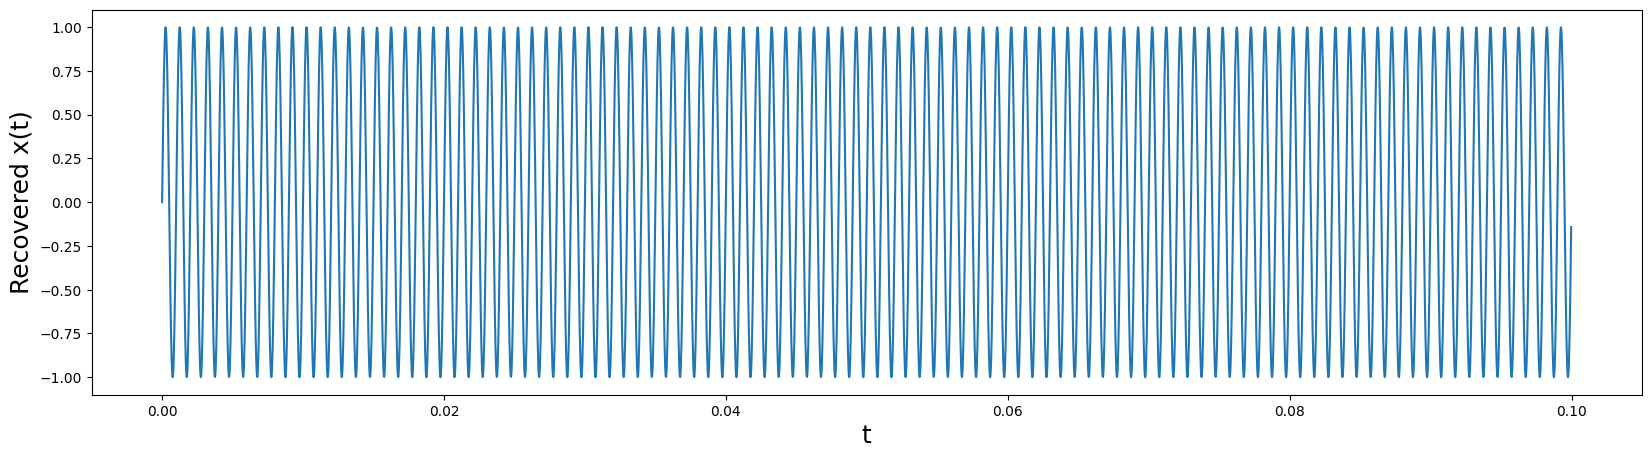

In [89]:
x_recovered = irfft(x_fft)
# just use the same `t` from before
plt.plot(t, x_recovered)
plt.xlabel('t', size=18)
plt.ylabel('Recovered x(t)', size=18)
plt.show()
plt.show()

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 1.1.</span> Choose some other pure tone frequencies and try them out in the cells above. Satisfy yourself that the FFT vector $x_\mathcal{F}[n]$, plotted against the correct frequency vector $f[n]$, will show the spike in the right place, and that the inverse FFT recovers the original signal. You might also try adding two pure tones (of different frequencies) together to see the outcome.

In [90]:
# Cell for Question 1.1
# plot frequency spectrum

In [91]:
# Cell for Question 1.1
# plot time domain signal

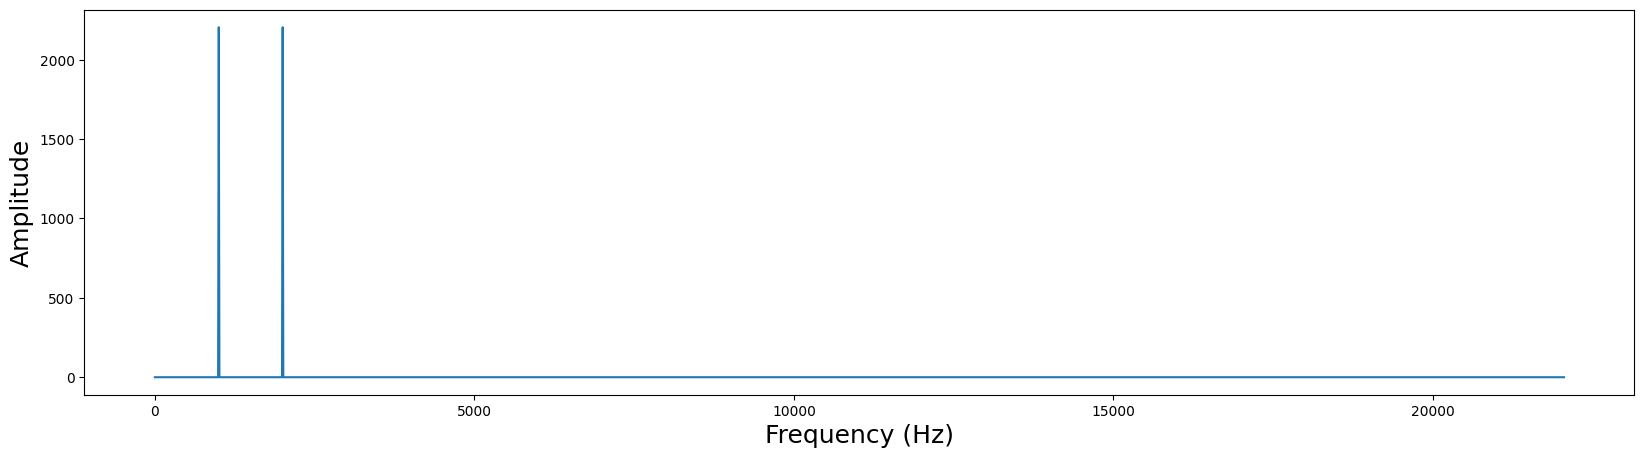

In [92]:
# solution code - delete before sending to students!

x = np.sin(2 * π * 1000 * t) + np.sin(2 * π * 2000 * t)

x_fft = rfft(x)
f_fft = rfftfreq(x.size, Ts)
plt.plot(f_fft, np.abs(x_fft))
plt.xlabel('Frequency (Hz)', size=18)
plt.ylabel('Amplitude', size=18);

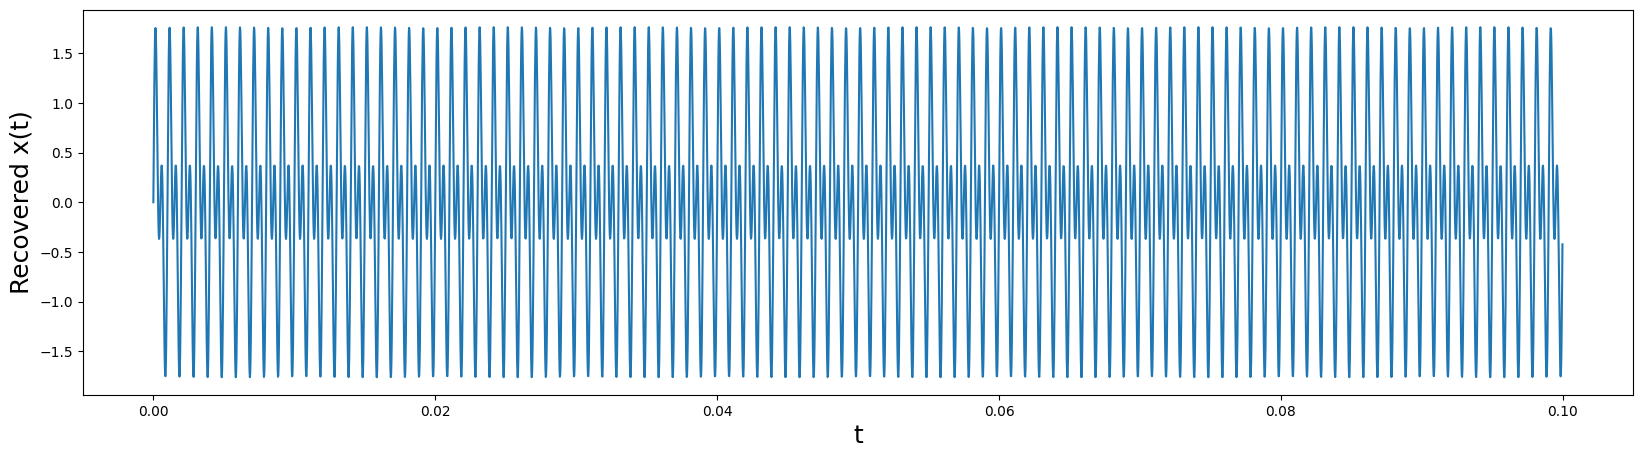

In [93]:
# solution code - delete before sending to students!

x_recovered = irfft(x_fft)

plt.plot(t, x_recovered)
plt.xlabel('t', size=18)
plt.ylabel('Recovered x(t)', size=18)
plt.show()
plt.show()

# Part 2: The spectrum of the transmitted signal (15 points)

We're now in a position to begin our investigation of the spectrum of our transmitted OOK signal. Let's start with the **baseband** (unmodulated) signal.

<div class="alert alert-info"><strong>Terminology:</strong> In this project, the <em>baseband signal</em>, <em>unmodulated signal</em> and <em>envelope signal</em> are all the same thing. Similarly, <em>passband signal</em> and <em>modulated signal</em> refer to the same thing. (In other contexts, there might be subtle differences between these terms, but in this project, there aren't.)</div>

### Spectrum of baseband (unmodulated, envelope) signal

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 2.1.</span> Use (_i.e._, copy) your code from Project 2a to generate a **baseband** (envelope) signal for a randomly generated message. Use the `rfft()` and `rfftfreq()` functions to plot the magnitude (`np.abs()`) of its spectrum.

Use the data rate you reported in Question 4.1 of Project 2a, the rate at which your decoding had around one bit error most of the time for the physical channel. Your message should be of a length that the entire transmission takes around 6 seconds.

<div class="alert alert-info">
    <p><strong>Zooming in on plots:</strong> If you want to zoom in horizontally on the plot, you can use the command <code>plt.xlim(xmin, xmax)</code> to specify the limits of the x-axis. For example, <code>plt.xlim(0, 10)</code> will restrict the plot to between 0 and 10 on the x-axis. This can allow you to zoom in on the parts of the spectrum that are more interesting.</p>
    <p>Similarly, you can use <code>plt.ylim(ymin, ymax)</code> to zoom in on the y-axis (vertically). This might allow you to more closely inspect the nonzero parts of the spectrum that aren't the big main spike.</p>
    <p><strong>If you do this</strong>, please present <strong>both</strong> the original plot <strong>and</strong> the zoomed in plot, with brief commentary about which part you zoomed in on. (It's okay to duplicate plotting code between cells to make this work.)</p>
</div>

In [94]:
# Question 2.1.
# Spectrum of the baseband (envelope) signal.
# This may involve copying some code from Project 2a.
# As always, add as many cells as you need to show what you want to show.

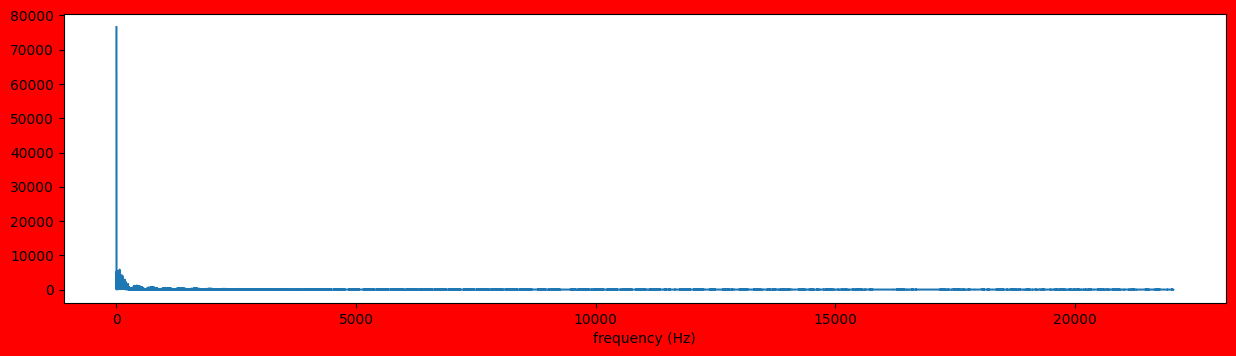

In [95]:
# solution code - delete before sending to students!

message = rng.integers(0, 2, 1100)
message = np.insert(message, 0, 1)  # always start the message with a 1 (we'll see why soon)

rate = 300
T = 1 / rate
k = len(message)
t = np.arange(0, k * T, 1 / fs)
baseband = message[np.floor(t / T).astype(int)]

f_fft = rfftfreq(baseband.size, 1 / fs)
baseband_fft = rfft(baseband)

fig = plt.figure(figsize=(15, 3.75))
fig.patch.set_facecolor('red')
plt.plot(f_fft, np.abs(baseband_fft))
plt.xlabel('frequency (Hz)')
plt.show()

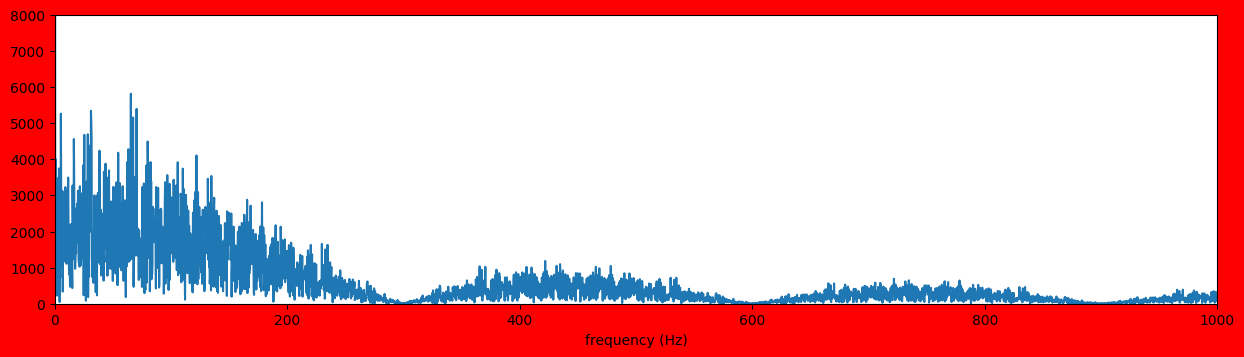

In [96]:
# solution code - delete before sending to students!

fig = plt.figure(figsize=(15, 3.75))
fig.patch.set_facecolor('red')
plt.plot(f_fft, np.abs(baseband_fft))
plt.xlabel('frequency (Hz)')
plt.xlim(0, 1000)
plt.ylim(0, 8000)
plt.show()

### Spectrum of modulated (passband) signal

Now modulate the signal and inspect its spectrum.

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 2.2.</span> Use (_i.e._, copy) your code from Project 2a to **modulate** your baseband signal to arrive at the **modulated (passband) signal** (_i.e._, multiply by a pure tone at your chosen carrier frequency), and plot the spectrum of the modulated signal.

<div class="alert alert-success" style="color: black;"><strong>General notes on plots.</strong> In all spectrum plots in this project, you should:
    <ul>
        <li>plot only the magnitude of the spectrum, <i>i.e.</i> take the <code>np.abs()</code> of the (complex) spectrum before plotting, and</li>
        <li>feel at liberty to zoom in to the plot using <code>plt.xlim()</code> (and <code>plt.ylim()</code> if you like), but please always present the original zoomed out plot as well, so we can see what you're zooming into.</li>
    </ul>
</div>

In [97]:
# Question 2.2.
# Spectrum of passband (modulated) signal.

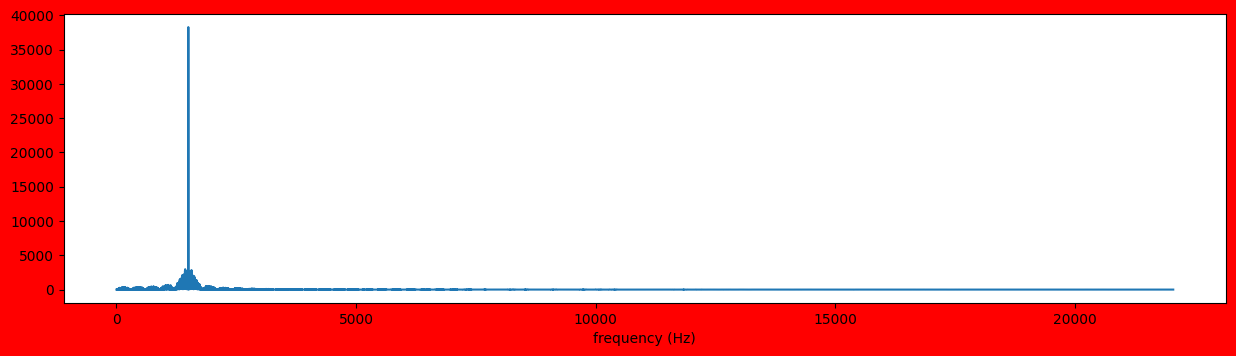

In [98]:
# solution code - delete before sending to students!

fc = 1500
x = np.sin(2 * π * fc * t) * baseband

f_fft = rfftfreq(x.size, 1 / fs)
x_fft = rfft(x)
fig = plt.figure(figsize=(15, 3.75))
fig.patch.set_facecolor('red')
plt.plot(f_fft, np.abs(x_fft))
plt.xlabel('frequency (Hz)')
plt.show()

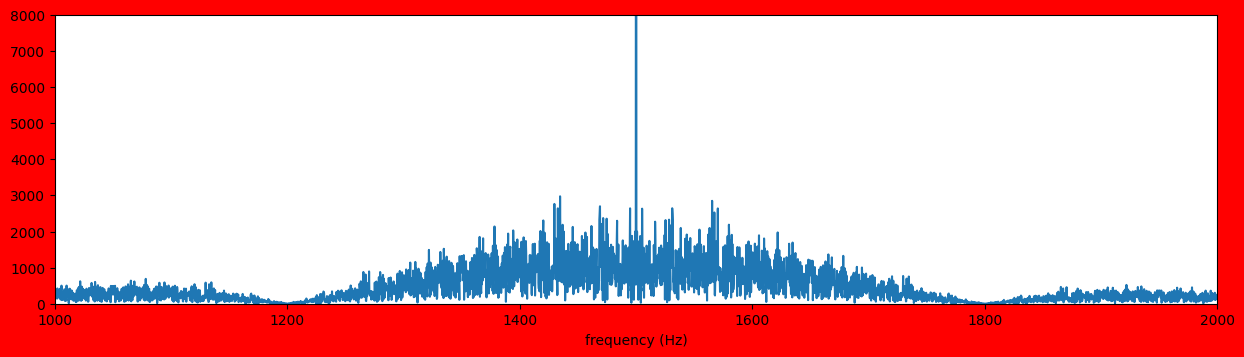

In [99]:
# solution code - delete before sending to students!

fig = plt.figure(figsize=(15, 3.75))
fig.patch.set_facecolor('red')
plt.plot(f_fft, np.abs(x_fft))
plt.xlabel('frequency (Hz)')
plt.xlim(1000, 2000)
plt.ylim(0, 8000)
plt.show()

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 2.3.</span> What is the relationship between the baseband and passband spectra? You should be able to describe in exact terms how, without taking the inverse FFT, one would arrive at the passband spectrum, given the baseband spectrum and the carrier frequency.

_WHAT WE EXPECT:_ a short answer with 1-2 sentences.

> YOUR ANSWER HERE (to Question 2.3)

> The spectrum of the passband signal is obtained by shifting the spectrum of the baseband signal to the carrier frequency fc.

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 2.4.</span> Double the data rate you used in Questions 2.1–2.2, and reproduce the same spectrum plot as in Question 2.2. How does this new spectrum compare to the original spectrum? Explain in terms of what you know about the relationship between bandwidth and data rate.

_WHAT WE EXPECT:_ a short answer with 1-2 sentences.

> YOUR ANSWER HERE (to Question 2.4)

> The doubled data rate spectrum shares the same general shape as the original, yet it is stretched horizontally by a factor of 2. From lecture, we know that an increase in the data rate is consistent with an increase in the bandwidth of the signal. Doubling the data rate is going to double the bandwidth. The total energy of the signal is going to remain the same, but it is now spread out over a 2x larger range of frequencies and so its power is more diluted per frequency which reduces the magnitude per unit of bandwidth.

In [100]:
# Question 2.4.
# Spectrum of passband signal, but for twice the data rate.

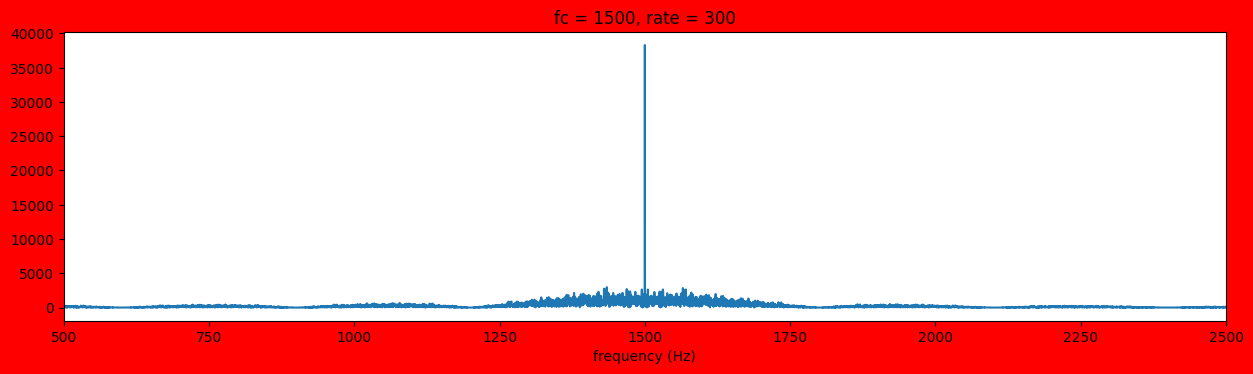

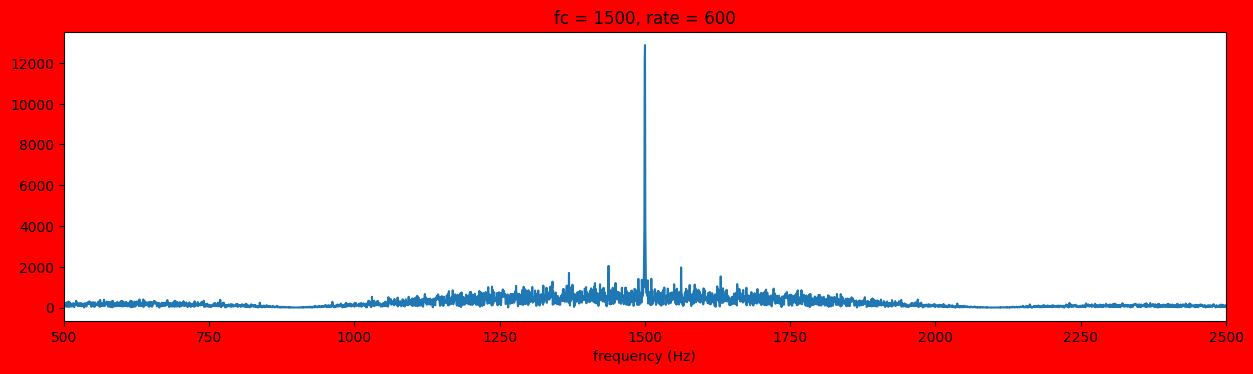

In [101]:
# Solution code - delete before sending to students!

# Rate = 300
rates = [300, 600]
for rate in rates:
    T = 1 / rate
    k = len(message)
    t = np.arange(0, k * T, 1 / fs)
    baseband = message[np.floor(t / T).astype(int)]

    fc = 1500
    x = np.sin(2 * π * fc * t) * baseband

    f_fft = rfftfreq(x.size, 1 / fs)
    x_fft = rfft(x)

    fig = plt.figure(figsize=(15, 3.75))
    fig.patch.set_facecolor('red')
    plt.plot(f_fft, np.abs(x_fft))
    plt.xlabel('frequency (Hz)')
    plt.xlim(500, 2500)
    #plt.ylim(0, 8000)
    plt.title(f'fc = {fc}, rate = {rate}')
    plt.show()

<div class="alert alert-warning" style="color: black;"><strong>Before you continue:</strong> Don't forget to restore your data rate to your original data rate, and regenerate your message and transmitted signal if necessary, before you continue on to Part 3!</div>

# Part 3: The spectrum of the received signal (25 points)

It's useful to understand the spectrum of the transmitted signal because it gives us an idea of what to expect from a "perfect received signal" (which is, in an ideal world, just a scaled version of the transmitted signal). In this part, we'll first inspect the spectrum of the received signal, and then we'll add external disturbances to see the effect on the spectrum.

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 3.1.a - simulated channel</span> Use your code from Project 2a to transmit and receive your modulated signal (using `channel0()`), and plot the spectrum of the received signal.

_Note:_ You should add the silence after the signal to make sure the entire OOK signal is recorded. However, you don't need to truncate the signal to detect its starting point accurately—just take the FFT of the whole thing. Note that this means your frequency vector $f[n]$ (generated by `rfftfreq()`) will be different to the one you used to plot the spectrum in Part 2.

<div class="alert alert-info">Reminder: You can zoom in using <code>plt.xlim()</code> and <code>plt.ylim()</code>, which you might do to look more closely at the “interesting” parts of the spectrum. It's okay to zoom in vertically in a way that pushes the main spike off the scale, if you want to look at other activity.</div>

<div class="alert alert-warning">You may reuse the (simulated) received signal in the subsequent questions, so to prevent error, <b> we suggest you to use a unique variable to store it </b> (e.g.,  <code>y_sim</code>).</div>

In [102]:
def add_silence(signal: np.ndarray) -> np.ndarray:
    """ Adds an appropriate amount of silence to the signal.
        - signal: 1-D array of floats
    Output variables:
        - new_signal: 1-D array of floats
    """
    silence = 1  # seconds
    new_signal = np.append(signal, np.zeros(int(silence * fs)))
    return new_signal


def generate_modulated_signal(message: np.ndarray, rate: float, fc: float) -> np.ndarray:
    """ Generate the modulated signal.
    Input variables:
        - message: 1-D array of ints
        - rate:    data rate in bits per second
        - fc:      carrier frequency in Hz
    Output variables:
        - signal: modulated signal as 1-D array of floats
    """
    T = 1 / rate
    k = len(message)
    t = np.arange(int(k*T*fs))/fs
    envelope = message[np.floor(t / T).astype(int)]
    signal = np.sin(2 * π * fc * t) * envelope
    return signal

In [103]:
# Question 3.1.a
# Spectrum of the received signal.

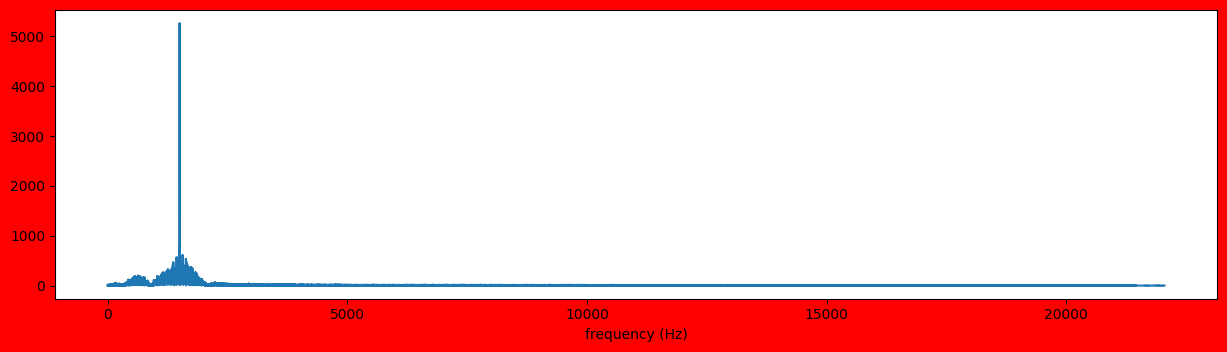

In [104]:
# solution code - delete before sending to students!
x_extended = add_silence(x)
y = channel0(x_extended)

fig = plt.figure(figsize=(15, 3.75))
fig.patch.set_facecolor('red')
fy_fft = rfftfreq(y.size, 1 / fs)
y_fft = rfft(y)
plt.plot(fy_fft, np.abs(y_fft))

plt.xlabel('frequency (Hz)')
plt.show()

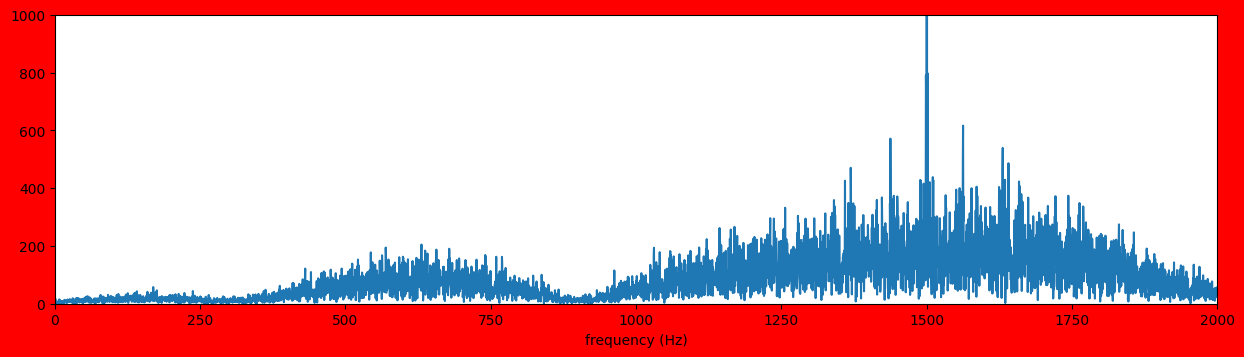

In [105]:
# solution code - delete before sending to students!

fig = plt.figure(figsize=(15, 3.75))
fig.patch.set_facecolor('red')
fy_fft = rfftfreq(y.size, 1 / fs)
y_fft = rfft(y)
plt.plot(fy_fft, np.abs(y_fft))
plt.xlabel('frequency (Hz)')
plt.xlim(0, 2000)
plt.ylim(0, 1000)
plt.show()


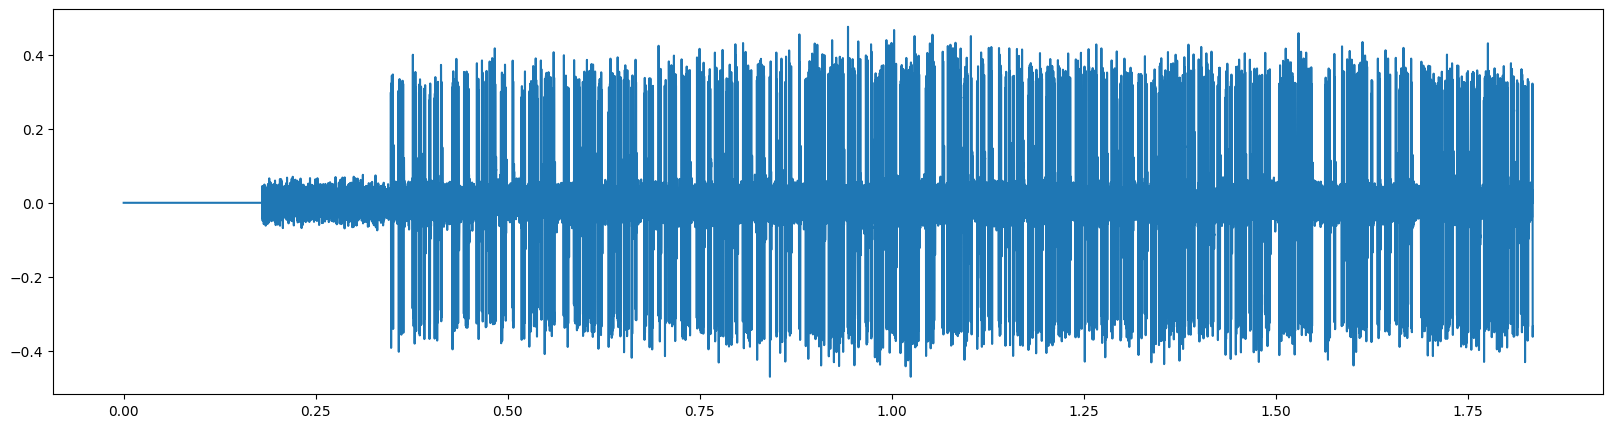

In [106]:
# solution code - delete before sending to students!

plt.plot(t, y[:len(t)])

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 3.2.</span> Comment on how this is similar to and different from the spectrum of the transmitted passband signal you found in Question 2.2. For example—is the spike in the same place, are there additional components or absent components?

_WHAT WE EXPECT: a short answer with 1-2 sentence.

> YOUR ANSWER HERE

> The spike appears at the same place as the transmitted signal, i.e., it is centered around the carrier frequency. The magnitude of the signal is slightly lower than the original one from 2.2. There is also some additional noise visible at low frequency areas.

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 3.3.- physical channel</span> The following cell records from your microphone for 6 seconds. Run it and talk out loud while it's recording. Just talk—anything will do. If you don't know what to say, try this paragraph ([source](https://www.newyorker.com/tech/annals-of-technology/claude-shannon-the-father-of-the-information-age-turns-1100100)):
> “Einstein looms large, and rightly so,” James Gleick told me. “But we’re not living in the relativity age, we’re living in the information age. It’s Shannon whose fingerprints are on every electronic device we own, every computer screen we gaze into, every means of digital communication. He’s one of these people who so transform the world that, after the transformation, the old world is forgotten.”

Then, plot the spectrum of your talking noise in the following cell.

_Optional:_ You might also like to plot the recorded signal (in the time domain), if you haven't seen what an audio of someone talking looks like before.

In [107]:
duration = 6
print("Recording for {} seconds...".format(duration))
noise = channel1(np.zeros(duration * fs))
print("... done.")

Recording for 6 seconds...
... done.


In [108]:
# Question 3.3.
# Spectrum of the "talking noise" recording.
# (You may also, optionally, plot the signal in the time domain in another cell.)

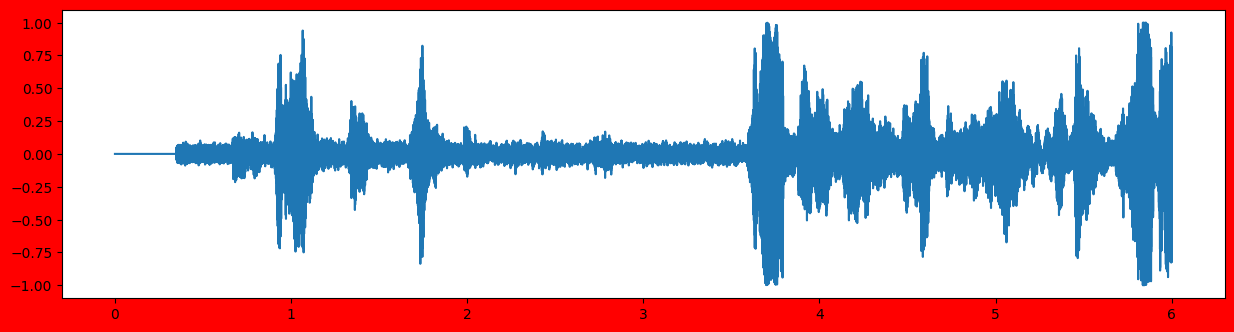

In [109]:
# solution code - delete before sending to students!

fig = plt.figure(figsize=(15, 3.75))
fig.patch.set_facecolor('red')
t = np.arange(0, noise.size) / fs
plt.plot(t, noise)
plt.show()

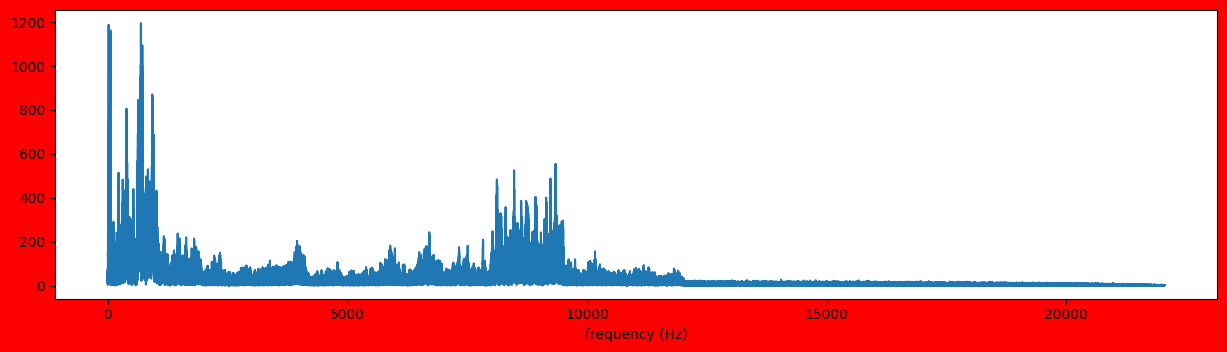

In [110]:
# solution code - delete before sending to students!

fig = plt.figure(figsize=(15, 3.75))
fig.patch.set_facecolor('red')
fn_fft = rfftfreq(noise.size, 1 / fs)
noise_fft = rfft(noise)
plt.plot(fn_fft, np.abs(noise_fft))
plt.xlabel('frequency (Hz)')
plt.show()

# Part 4: Filtering to extract the signal of interest (25 points)

Recall from Project 1b that a **filter** is an operation that extracts some frequency components, and sets all others to zero.

In this case, we want to keep the frequencies that are likely to be relevant to our OOK signal, and to discard the ones that aren't. This isn't necessarily a clean-cut decision. You'll have noticed in Part 3 that there's some overlap involved. Nonetheless, we can "clean up" our signal quite a lot by choosing cutoff frequencies strategically.

Because our frequencies have physical meanings, our filter implementation will be a little more involved than the filter from Project 1b. Remember the scaling for frequencies we had to do so that we can plot spectra with accurate frequency axes? We'll need to do that here, too. So we'll first write a function that modifies a spectrum by retaining _only_ those frequencies within a _passband_, between `fmin` and `fmax`.

(On the other hand, we only have to deal with one dimension in this one!)


<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 4.1.</span> Write a function `bandpass()` that takes a spectrum (as returned by `rfft()`) and sampling frequency `fs`, and returns the same spectrum with all values outside the frequency range between `fmin` and `fmax` set to zero.

- The tricky part of this function is that you'll need to “convert” `fmin` and `fmax` to indices of the `spectrum` vector. To do this, recall from earlier that, where $f_s$ is the sampling frequency and $N$ is the length of the original vector,
  $$f[n] = \frac{f_s}{N} \cdot n.$$
- Your function should not need to use `rfft()` or `irfft()`, because it is only working in the frequency domain. In subsequent cells, call these functions separately to `bandpass()`.
- If you use `np.zeros()` (or a similar function) to initialize a new array, add the keyword argument `dtype=complex`. This will make sure the array expects to take complex numbers, since the spectrum is complex.
- You shouldn't need to modify any of the complex numbers in the array, other than to replace them with zero.
- Note that your filter can either include or exclude $f_\text{min}$ and $f_\text{max}$. We will not be strict about this.

In [111]:
def bandpass(spectrum, fs, fmin, fmax):
    # replace this line
    return np.zeros(spectrum.size, dtype=complex)

In [112]:
# solution code - delete before sending to students!

def bandpass(spectrum, fs, fmin, fmax):
    filtered = np.zeros(spectrum.size, dtype=complex)
    N = 2 * spectrum.size
    imin = int(fmin * N / fs)
    imax = int(fmax * N / fs)
    filtered[imin:imax] = spectrum[imin:imax]
    return filtered

<div class="alert alert-info">Questions 4.2.a to 4.2.c are really part of the same question, but we've separated them to make clear which plots we want to see. You might consider returning to Question 4.2.a to reselect your cutoff frequencies after doing Question 4.2.c</div>

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 4.2.a - simulated channel </span> Apply the bandpass filter to the spectrum of your noisy signal from the simulated channel in Question 3.1.a. Plot the resulting filtered signal in both the time domain and the frequency domain. You should use this plot to verify that your `bandpass()` implementation works as intended.

You'll need to choose the cutoff frequencies `fmin` and `fmax`. You should choose them based on what you notice about the spectra in Part 3. It's fine (and encouraged) to return to this question later and choose different cutoff frequencies, if you change your mind after Question 4.2.c.

<div class="alert alert-warning">Note that the noisy signal in Question 3.1.a is free from "interference," such as human talking noise introduced in Question 3.6, so filtering is unnecessary for decoding. You can use a simple energy-based decoder as in Project 2a. The intention of this question is primarily to serve as a sanity check to your filtering implementation. However, in the following questions (Q4.3.a - Q4.3.c) where the received signal is affected by human voice contamination, filtering should enhance your decoding. </div>

In [113]:
# Question 4.2.a.
# Plots of filtered signal in time and frequency domain.

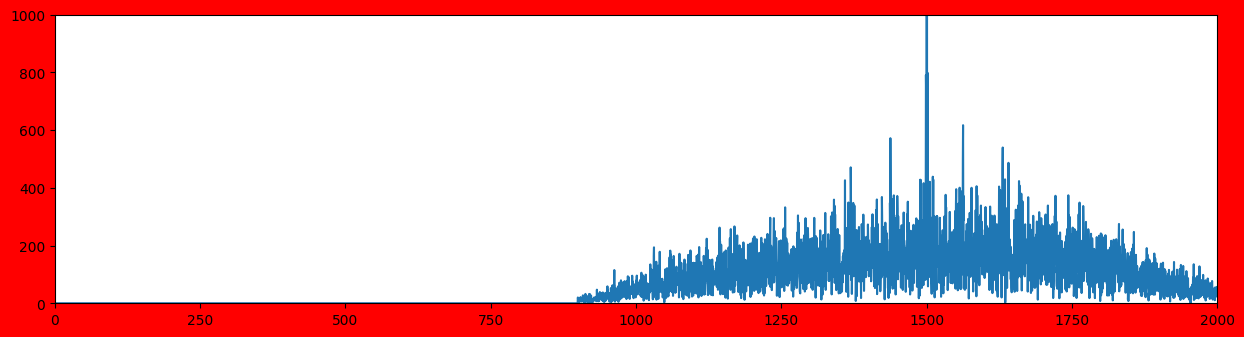

In [120]:
# solution code - delete before sending to students!

# Load the signal
fy_fft = rfftfreq(y.size, 1 / fs)
y_fft = rfft(y)

# Filter the spectrum
y_fft_filtered = bandpass(y_fft, fs, fc - rate, fc + rate)

fig = plt.figure(figsize=(15, 3.75))
fig.patch.set_facecolor('red')
plt.plot(fy_fft, np.abs(y_fft_filtered))
plt.xlim(0, 2000)
plt.ylim(0, 1000)
plt.show()

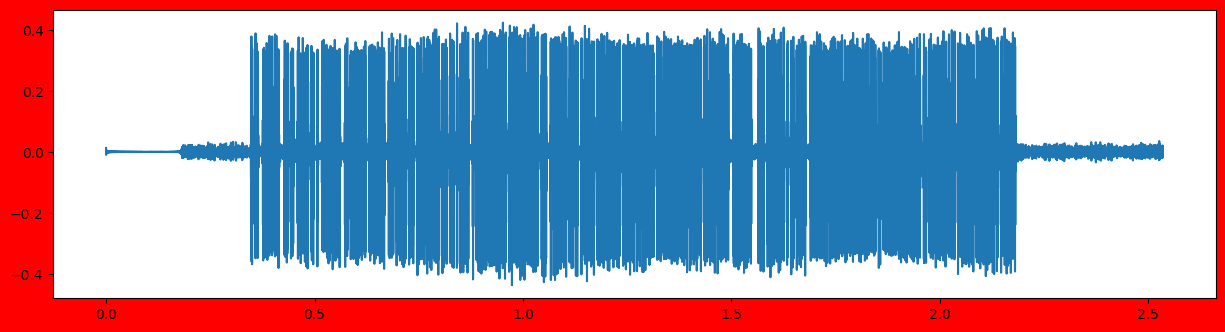

In [121]:
# solution code - delete before sending to students!

y_filtered = irfft(y_fft_filtered)
t = np.arange(0, y_filtered.size) / fs
fig = plt.figure(figsize=(15, 3.75))
fig.patch.set_facecolor('red')
plt.plot(t, y_filtered)
plt.show()

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 4.2.b - simulated channel</span> If you haven't already, zoom in to a section of the time-domain signal that's about 10 to 15 symbols long. Plot both the unfiltered received signal, and the filtered signal (on different axes), in the same zoomed-in section.
(If you did this during Question 4.2.a., just leave a note in the answer below telling us to look above.)

In [116]:
# Question 4.2.b.
# Plots of unfiltered and filtered signals.

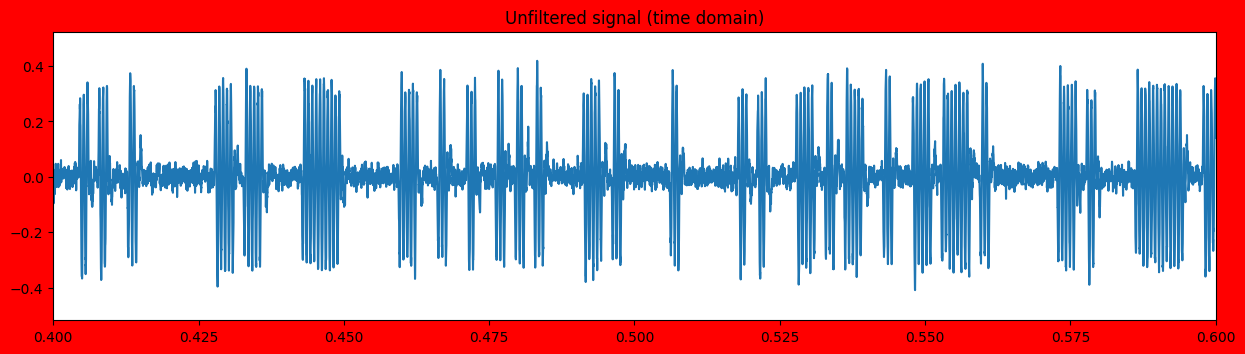

In [122]:
# solution code - delete before sending to students!

t = np.arange(0, y.size) / fs

fig = plt.figure(figsize=(15, 3.75))
fig.patch.set_facecolor('red')
plt.plot(t, y)
plt.title("Unfiltered signal (time domain)")
plt.xlim(0.4, 0.6)
plt.show()

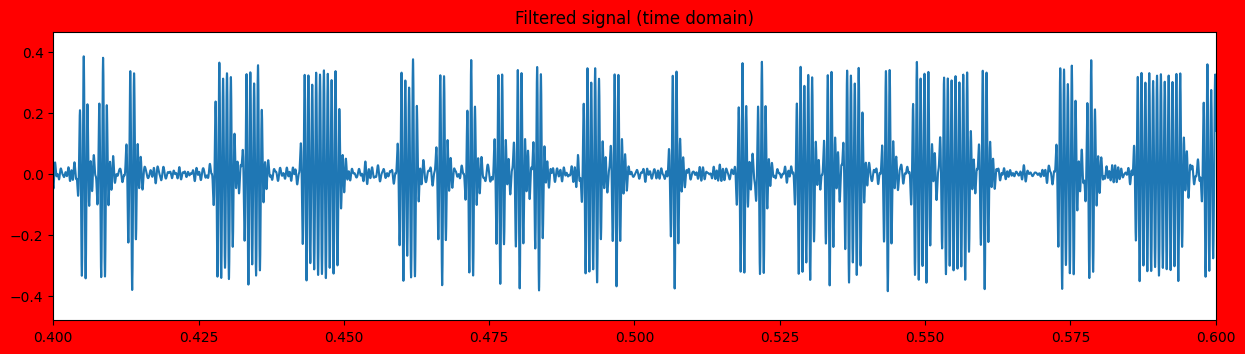

In [123]:
# solution code - delete before sending to students!

t = np.arange(0, y_filtered.size) / fs

fig = plt.figure(figsize=(15, 3.75))
fig.patch.set_facecolor('red')
plt.plot(t, y_filtered)
plt.title("Filtered signal (time domain)")
plt.xlim(0.4, 0.6)
plt.show()

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 4.2.c - simulated channel</span> Decode the _filtered_ signal using the same techniques that you used in Project 2a (and Question 3.6). Report the bit error rate. How does this compare to your previous error rate in Question 3.6?

<div class="alert alert-success">It's acceptable to go back to Question 4.2.a. at this point, and re-tune your cutoff frequencies.</div>

<div class="alert alert-success"><strong>General note:</strong> You might find it helpful to plot the received signal and visualize the energy values, possibly after zooming in. This can help you find any bugs in the code, or to set the thresholds at an appropriate level. You should check this whenever you make any major changes to the parameters, or when you can't properly understand why you are getting bad performance.</div>

In [126]:
# solution code - delete before sending to students!
def detect_start(signal, visual_test=False):
    # you should define start_threshold and start_index as explained above
    absolute_values = np.abs(signal)
    rms = np.sqrt(np.mean(signal ** 2))
    start_threshold = rms*np.sqrt(2)
    start_index = np.nonzero(absolute_values > start_threshold)[0][0]

    if visual_test:
        visualize(signal, start_threshold, start_index, None)
    return start_index


def demodulate(signal: np.ndarray, rate: float, length: int) -> np.ndarray:
    """ Demodulate the receieved signal
    Input variables:
        - signal:  1-D array of ints
        - rate:    data rate in bits per second
        - length   expected length of message
    Output variables:
        - decoded: modulated signal as 1-D array of floats
    """
    start_index = detect_start(signal)
    bit_threshold = np.mean(signal[start_index:] ** 2) / 2

    decoded = np.zeros(length, dtype = np.int8)
    for i in range(length):
        start = (i * fs) // rate + start_index
        end = ((i + 1) * fs) // rate + start_index
        power = np.mean(signal[int(start): int(end)] ** 2)
        decoded[i] = 1 if (power > bit_threshold) else 0

    return decoded

demodulated = demodulate(y_filtered, rate, message.size)
np.sum(demodulated != message) / message.size

np.float64(0.0)

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question 4.4.</span> How did you end up choosing your filter cutoff frequencies? Explain your thinking.

_WHAT WE EXPECT:_ a short answer with 1-2 sentences.

> YOUR ANSWER HERE

> You can look at spectrum of the noisy signal determine which parts of frequencies to zero-out to eliminate the voice interference. Alternatively, you can deterimine the cut-off frequencies from what we learned from the lecture: $$[f_{\text{min}}, f_{\text{max}}] = [f_c - f_{\text{data}}, f_c + f_{\text{data}}],$$
> where $ f_{\text{data}} $ is the data rate.

# Analysis (5 points)

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question A1.</span> For what kinds of noise or interference would the filtering strategy we implemented in this project _not_ be effective? What sort of coordination might be necessary if there are multiple transmitters operating in the same space?

_WHAT WE EXPECT:_ a paragraph explaining your thoughts.

> YOUR ANSWER HERE

> If there was interference/noise of the same frequency range, the filtering strategy would do little to be helpful. If there is a chance of noise in the same area, the two groups should choose different carrier frequencies to transmit their respective signals. Doing so would not corrupt their signal, but rather allow for each to be able to decode their own on seperate filters.

# Reflection (5 points)

<span style="background-color: #8C1515; font-weight: bold; color: white;">Question R1.</span> Here it is: https://forms.gle/ybs64YdGfeUC8ikV6

# <font color="blue"> Submission guidelines</font>

## Export this Jupyter notebook as a PDF file

- After finishing all the questions, make sure they display properly.
- Save this notebook as a pdf file. Feel free to use any method for exporting the PDF, provided that the resulting document remains readable. Below are a few options:

    1. We suggest the simplest approach: save the notebook as an HTML file, open it in a web browser, then right-click the page and select "Print" to generate a PDF.
    2. Another way to convert your .ipynb files to .pdf is to upload the .ipynb file to Google Drive, and then double-clicking the file to open it in Google Colaboratory. You should see that all of your code and code outputs are there. **Please be sure to not run any cells on Colab, as this will overwrite your output!** You can then click File > Print, and then select Save as PDF in the print dialog.
    3. You can also convert your notebook in the following websites:
        - https://onlineconvertfree.com/convert/ipynb/
        - https://2pdf.com/convert-ipynb-to-pdf/

## What and where to submit

Submit this Jupyter notebook  and the PDF to Gradescope. There are two portals, one for the PDF and the other for the notebook. We won't use the autograder this time, so the `.ipynb` notebook will only be used when we need to verify the correctness of your code.


- Submit this Jupyter notebook file (as a .ipynb file) to the "**Project 2b (jupyter-notebook)**" assignment on Gradescope.
- Submit the PDF to the "**Project 2b (PDF)**"
- Don't forget to fill out the reflection form!


## Coding style and formatting (5 points)

- Coding style: This isn't a development project, so we don't plan to be very particular about this. But we still have to read your code, so please try to make that reasonably painless for us. For example, please remove commented-out code and redundant variables before you submit.

- Formatting: In addition to coding style, please make sure that your exported PDF is readable (for example, your submission shouldn't be a long, single-paged PDF file) and that all the questions are properly tagged. Hopefully these 5 points will be effectively free points.